# RAISE the Bar: Restriction of Action Spaces for Improved Social Welfare and Equity in Traffic Management
## Random Erdős-Rényi graph experiment

### Setup and function definitions

In [1]:
# Internal modules
import itertools
import math

# External modules
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm, trange
import statsmodels.formula.api as sm
from scipy import interpolate

# Own modules
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

from src.environment import TrafficModel, Car, create_cars, build_network, UniformLatencyGenerator
from src.analysis import compute_regression, analyze_fairness
from src.util import change_value_of_money

plt.rcParams['text.usetex'] = True

In [2]:
def create_random_gnp_graph(number_of_nodes, p, latency_generator, *, seed=42):
    network = nx.gnp_random_graph(number_of_nodes, p, seed=seed, directed=True)

    nx.set_node_attributes(
        network,
        nx.circular_layout(network, dim=3, scale=10),
        "position",
    )

    nx.set_edge_attributes(
        network,
        {edge: latency_generator() for edge in network.edges},
        "latency_params",
    )

    return build_network(network)

In [3]:
def interpolate_travel_times(car_travel_times):
    interpolated_car_stats = pd.DataFrame()
    for seed in car_travel_times.seed.unique():
        grouped_seed_car_stats = car_travel_times[car_travel_times['seed'] == seed].groupby('step').mean().reset_index()

        interpolation_function = interpolate.interp1d(grouped_seed_car_stats['step'],
                                                      grouped_seed_car_stats['travel_time'],
                                                      fill_value="extrapolate")

        interpolation_results = pd.DataFrame({'step': range(1, 10001)})
        interpolation_results.set_index('step')
        interpolation_results['travel_time'] = interpolation_results.apply(lambda x: interpolation_function(x.index))
        interpolation_results['seed'] = seed
        interpolated_car_stats = pd.concat([interpolated_car_stats, interpolation_results])

    return interpolated_car_stats

In [4]:
BASE_COLOR = 'aqua'
RESTRICTION_COLOR = 'coral'
TOLLING_COLOR = 'darkred'

### Experiment

In [59]:
number_of_nodes = 50
p = 0.070711
car_seeds = [41, 42, 43, 44, 45, 46]
number_of_steps = 10000
values_of_money = [0, 1, 2, 5]
car_counts = {(23, 33): 38}

results = []
unrestricted_car_travel_times = pd.DataFrame(columns=['step', 'seed', 'travel_time'])
restricted_car_travel_times = pd.DataFrame(columns=['step', 'seed', 'travel_time', 'improvement'])
tolling_car_travel_times = pd.DataFrame(columns=['step', 'seed', 'travel_time', 'improvement'])
total_cost_car_travel_times = pd.DataFrame(columns=['step', 'seed', 'travel_time'])
for seed in car_seeds:
    print(f'Running with seed {seed}.')
    # Unrestricted
    network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                      latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                      seed=46)
    cars = create_cars(network, car_counts=car_counts, seed=seed)
    change_value_of_money(cars, values_of_money, seed=seed)
    model = TrafficModel(network, cars, seed=seed)
    step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)

    grouped_car_stats = car_stats_unrestricted[['step', 'travel_time']]\
        .groupby('step').mean().expanding().mean().reset_index()
    grouped_car_stats['seed'] = seed
    unrestricted_car_travel_times = pd.concat([unrestricted_car_travel_times, grouped_car_stats])

    results.append({'seed': seed,
                    'scenario': 'Base',
                    'travel_time': car_stats_unrestricted["travel_time"][-5000:].mean(),
                    **analyze_fairness(car_stats_unrestricted),
                    **{index: value for index, value in car_stats_unrestricted[-5000:]
                   .groupby('value_of_money')['travel_time'].mean().items()}})

    # Restricted
    network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                      latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                      seed=46)
    cars = create_cars(network, car_counts=car_counts, seed=seed)
    model = TrafficModel(network, cars, seed=seed)

    model.set_edge_restriction((23, 30), allowed=False)
    model.cars = create_cars(network, car_counts=car_counts, seed=seed)
    change_value_of_money(model.cars, values_of_money, seed=seed)

    step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)

    grouped_car_stats = car_stats_restricted[['step', 'travel_time']]\
        .groupby('step').mean().expanding().mean().reset_index()
    grouped_car_stats['seed'] = seed
    restricted_car_travel_times = pd.concat([restricted_car_travel_times, grouped_car_stats])

    results.append({'seed': seed,
                    'scenario': 'Restricted',
                    'travel_time': car_stats_restricted["travel_time"][-5000:].mean(),
                    **analyze_fairness(car_stats_restricted),
                    **{index: value for index, value in car_stats_restricted[-5000:]
                   .groupby('value_of_money')['travel_time'].mean().items()}})

    # Tolling
    network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                      latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                      seed=46)
    cars = create_cars(network, car_counts=car_counts, seed=seed)
    change_value_of_money(cars, values_of_money, seed=seed)
    model = TrafficModel(network, cars, tolls=True, beta=1.0, R=7.5e-4, seed=seed)
    step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)

    grouped_car_stats = car_stats_tolling[['step', 'travel_time']]\
    .groupby('step').mean().expanding().mean().reset_index()
    grouped_car_stats['seed'] = seed
    tolling_car_travel_times = pd.concat([tolling_car_travel_times, grouped_car_stats])

    results.append({'seed': seed,
                    'scenario': 'Tolling (excl. tolls)',
                    'travel_time': car_stats_tolling["travel_time"][-5000:].mean(),
                    **analyze_fairness(car_stats_tolling),
                    **{index: value for index, value in car_stats_tolling[-5000:]
                   .groupby('value_of_money')['travel_time'].mean().items()}})

    grouped_car_stats = car_stats_tolling[['step', 'total_cost']]\
    .groupby('step').mean().expanding().mean().reset_index()
    grouped_car_stats.columns = ['step', 'travel_time']

    grouped_car_stats['seed'] = seed
    total_cost_car_travel_times = pd.concat([total_cost_car_travel_times, grouped_car_stats])

    results.append({'seed': seed,
                    'scenario': 'Tolling (incl. tolls)',
                    'travel_time': car_stats_restricted["total_cost"][-5000:].mean(),
                    **analyze_fairness(car_stats_restricted),
                    **{index: value for index, value in car_stats_restricted[-5000:]
                   .groupby('value_of_money')['total_cost'].mean().items()}})

results = pd.DataFrame(results).set_index(['scenario'])
results = results.reset_index()

print('Interpolating travel times...')
unrestricted_car_travel_times = interpolate_travel_times(unrestricted_car_travel_times)
restricted_car_travel_times = interpolate_travel_times(restricted_car_travel_times)
tolling_car_travel_times = interpolate_travel_times(tolling_car_travel_times)
total_cost_car_travel_times = interpolate_travel_times(total_cost_car_travel_times)
print('DONE!')

Running with seed 41.
Running with seed 42.
Running with seed 43.
Running with seed 44.
Running with seed 45.
Running with seed 46.
Interpolating travel times...
DONE!


p-value: 0.4487162093018131
p-value: 0.6266801646992581
p-value: 0.012181583923007817


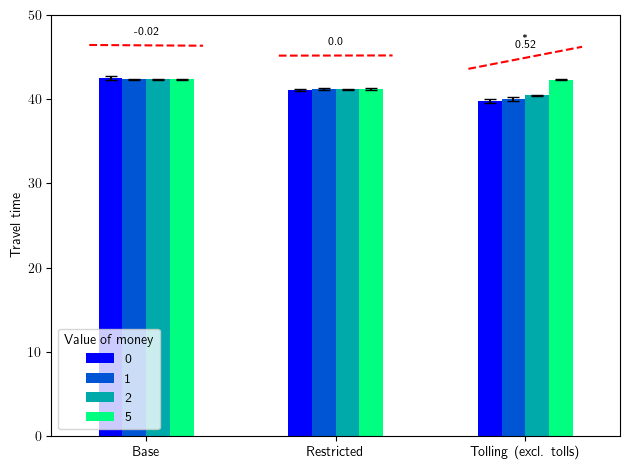

In [91]:
df = results[['scenario', 0, 1, 2, 5]].groupby('scenario')
df_mean = df.mean().drop(['Tolling (incl. tolls)'], axis='index')
df_std = df.std().drop(['Tolling (incl. tolls)'], axis='index')

ax = df_mean.plot.bar(cmap=mpl.colormaps['winter'], capsize=4, yerr=df_std)
ax.legend(loc='lower left', title='Value of money')
plt.xticks(rotation = 0)
ax.set_ylabel('Travel time')
ax.set_xlabel(None)
ax.set_ylim([0, 50])

# Add regression lines
for offset, (_, data) in enumerate(df_mean.iterrows()):
    data = data.reset_index()
    data.columns = ['value', 'time']
    ols = sm.ols(formula='time ~ value', data=data).fit()
    print(f'p-value: {ols.pvalues["value"]}')
    slope = ols.params['value']
    intercept = ols.params['Intercept']
    ax.plot([offset - 0.3, offset + 0.3],
            [intercept + slope * min(values_of_money) + 4.0,
             intercept + slope * max(values_of_money) + 4.0],
            'r--')

    ax.text(offset, ((intercept + slope * min(values_of_money) + 4.0)
                     + (intercept + slope * max(values_of_money) + 4.0)) / 2 + 1.2,
            str(np.round(slope, 2)) if np.round(slope, 2) != -0.0 else '0.0',
            horizontalalignment='center', fontsize=8, fontweight=100)

    if offset == 2:
        ax.text(2, ((intercept + slope * min(values_of_money) + 4.0)
                         + (intercept + slope * max(values_of_money) + 4.0)) / 2 + 2.2,
                '*',
                horizontalalignment='center', fontsize=8)

plt.tight_layout()
ax.get_figure().savefig('fairness.pdf', dpi=300)

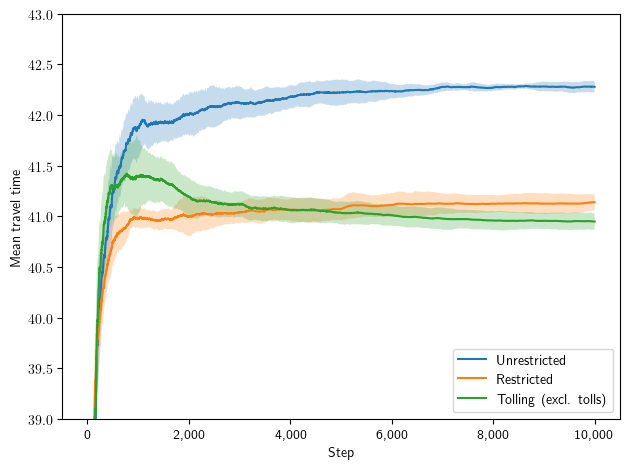

In [94]:
mean = unrestricted_car_travel_times.groupby('step')['travel_time'].mean()
std = unrestricted_car_travel_times.groupby('step')['travel_time'].std()
ax = mean.plot(xlabel='step', label='Unrestricted')
ax.fill_between(std.index,
                mean - std,
                mean + std,
                alpha=0.25)

mean = restricted_car_travel_times.groupby('step')['travel_time'].mean()
std = restricted_car_travel_times.groupby('step')['travel_time'].std()
ax = mean.plot(xlabel='step', label='Restricted')
ax.fill_between(std.index,
                mean - std,
                mean + std,
                alpha=0.25)

mean = tolling_car_travel_times.groupby('step')['travel_time'].mean()
std = tolling_car_travel_times.groupby('step')['travel_time'].std()
ax = mean.plot(xlabel='step', label='Tolling (excl. tolls)')
ax.fill_between(std.index,
                mean - std,
                mean + std,
                alpha=0.25)

ax.legend(loc='lower right')
ax.set_xlabel('Step')
ax.set_ylabel('Mean travel time')
ax.set_ylim([39, 43])
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
ax.get_figure().savefig('absolute-travel-time.pdf', dpi=300)

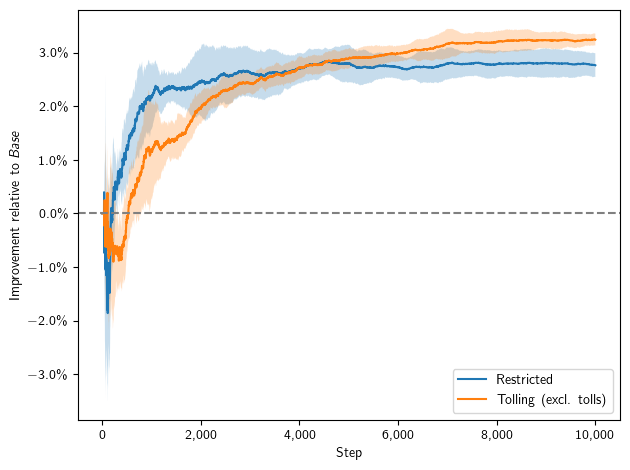

In [95]:
improvements =  unrestricted_car_travel_times.groupby(['step', 'seed'])['travel_time'].mean().div(
    restricted_car_travel_times.groupby(['step', 'seed'])['travel_time'].mean()).sub(1.0).reset_index().groupby('step')
mean = improvements.mean()['travel_time']
std = improvements.std()['travel_time']
ax = mean.plot(label='Restricted')
ax.fill_between(std.index,
                mean - std,
                mean + std,
                alpha=0.25)

improvements =  unrestricted_car_travel_times.groupby(['step', 'seed'])['travel_time'].mean().div(
    tolling_car_travel_times.groupby(['step', 'seed'])['travel_time'].mean()).sub(1.0).reset_index().groupby('step')
mean = improvements.mean()['travel_time']
std = improvements.std()['travel_time']
ax = mean.plot(label='Tolling (excl. tolls)')
ax.fill_between(std.index,
                mean - std,
                mean + std,
                alpha=0.25)

ax.legend(loc='lower right')
ax.set_xlabel('Step')
ax.set_ylabel('Improvement relative to \emph{Base}')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.axhline(ls='--', color='grey')
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
ax.get_figure().savefig('relative-travel-time.pdf', dpi=300)

### Tolling Optimization

In [ ]:
from sklearn.model_selection import ParameterGrid


number_of_nodes = 50
p = 0.070711
number_of_steps = 10000
values_of_money = [0, 1, 2, 5]
car_counts = {(23, 33): 38}


def evaluate(beta, R):
    network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                  latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                  seed=46)
    cars = create_cars(network, car_counts=car_counts, seed=46)
    change_value_of_money(cars, values_of_money)
    model = TrafficModel(network, cars, tolls=True, beta=beta, R=R)
    _, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=True)
    return car_stats_tolling["travel_time"][-5000:].mean()


res = []
for index, params in enumerate(ParameterGrid({
    'beta': [1.0],
    'R': [0.0, 0.00000001, 0.00000005, 0.0000001, 0.00000025, 0.0000005, 0.00000075, 0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075,
          0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
})):
    print(f'Evaluating {params} ({index})')
    res.append({**params,
                'travel time': evaluate(**params)})

In [55]:
optimization_results = pd.DataFrame(res)
optimization_results.sort_values(by='travel time').head()

,R,beta,travel time
18,0.00075,1.0,40.7540
16,0.00025,1.0,40.7584
19,0.00100,1.0,40.7892
17,0.00050,1.0,40.7920
20,0.00250,1.0,40.8704


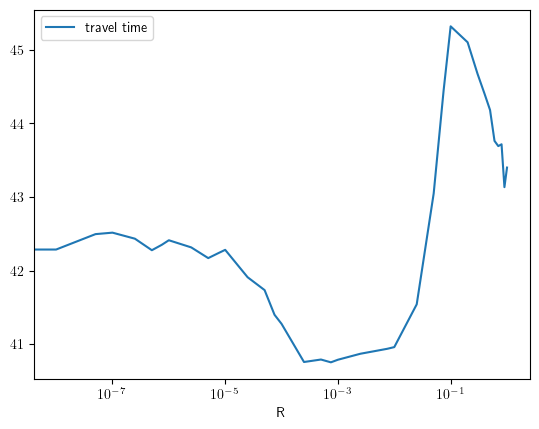

In [53]:
ax = optimization_results[['R', 'travel time']].set_index('R').plot()
ax.set_xscale('log')